# Cuaderno 3: Modelo Avanzado con Deep Learning (1D-CNN)

**Objetivo:** Construir, entrenar y evaluar una Red Neuronal Convolucional 1D (1D-CNN) para la clasificación de sonidos respiratorios. El objetivo es superar el rendimiento del modelo baseline de Random Forest, especialmente en la capacidad de generalizar y clasificar correctamente las clases minoritarias.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Importaciones de Scikit-learn (para evaluación)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


In [3]:
from tqdm import tqdm


In [4]:
# Añadir src al path para poder importar nuestros módulos
sys.path.append('../src')
from data_loader import build_metadata_df, load_audio_segment, bandpass_filter, normalize_signal

# --- Configuración del Proyecto ---
# Configuración general
sns.set_theme(style="whitegrid")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configuración del Modelo y Entrenamiento
RANDOM_SEED = 42
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
logger.info(f"Usando dispositivo: {DEVICE}")

# Configuración de los datos
# Todos los audios tendrán esta longitud en muestras. 4 * 22050 = 88200 muestras
FIXED_LENGTH_SAMPLES = 4 * 22050 
# Rutas
# Rutas
import kagglehub
dataset_path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")
DATASET_ROOT_PATH = Path(dataset_path)
MODEL_OUTPUT_PATH = Path("../models/")
MODEL_OUTPUT_PATH.mkdir(exist_ok=True) # Asegura que la carpeta exista

# --- AÑADE O VERIFICA ESTA LÍNEA ---
BEST_MODEL_PATH = MODEL_OUTPUT_PATH / "cnn_best_model.pth"


2025-07-23 19:31:30,223 - INFO - Usando dispositivo: cpu


## 1. Preparación de Datos para Deep Learning

A diferencia de los modelos clásicos, las redes neuronales requieren que todas las entradas tengan exactamente el mismo tamaño. Crearemos una clase `Dataset` personalizada de PyTorch que se encargará de:
1.  Cargar cada segmento de audio.
2.  Preprocesarlo (filtrar y normalizar).
3.  **Ajustar su longitud:** si un audio es más corto que `FIXED_LENGTH_SAMPLES`, se le añadirá relleno (padding) con ceros; si es más largo, se truncará.
4.  Convertir la señal y la etiqueta a tensores de PyTorch.


In [5]:
class RespiratorySoundDataset(Dataset):
    """Dataset personalizado para los sonidos respiratorios."""
    
    def __init__(self, df: pd.DataFrame, le: LabelEncoder, fixed_length: int):
        self.df = df
        self.le = le
        self.fixed_length = fixed_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Cargar y preprocesar el audio
        signal, sr = load_audio_segment(row['audio_path'], row['start_time'], row['end_time'])
        signal_filtered = bandpass_filter(signal, sr, lowcut=100, highcut=1999) # Usamos 1999 por seguridad
        signal_norm = normalize_signal(signal_filtered)
        
        # Ajustar longitud (padding o truncamiento)
        if len(signal_norm) < self.fixed_length:
            # Padding
            padding = self.fixed_length - len(signal_norm)
            signal_padded = np.pad(signal_norm, (0, padding), 'constant')
        else:
            # Truncamiento
            signal_padded = signal_norm[:self.fixed_length]
            
        # Añadir una dimensión de canal y convertir a tensor
        signal_tensor = torch.tensor(signal_padded, dtype=torch.float32).unsqueeze(0)
        
        # Obtener y convertir la etiqueta
        label = self.le.transform([row['diagnosis']])[0]
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return signal_tensor, label_tensor


## 2. Carga y División de Datos

Ahora usamos nuestra clase `Dataset` para crear los conjuntos de datos. Dividimos primero el DataFrame de metadatos en entrenamiento, validación y prueba para asegurar que no haya fuga de datos entre los conjuntos. Luego, envolvemos cada subconjunto en un `DataLoader` de PyTorch, que gestionará la creación de lotes (batches) y la aleatorización de los datos durante el entrenamiento.


In [6]:
# Cargar metadatos
metadata_df = build_metadata_df(DATASET_ROOT_PATH)

# Crear y ajustar el LabelEncoder
le = LabelEncoder()
metadata_df['diagnosis_encoded'] = le.fit_transform(metadata_df['diagnosis'])
NUM_CLASSES = len(le.classes_)

# Dividir los datos: 80% entrenamiento, 10% validación, 10% prueba
train_val_df, test_df = train_test_split(
    metadata_df, test_size=0.1, random_state=RANDOM_SEED, stratify=metadata_df['diagnosis']
)
train_df, val_df = train_test_split(
    train_val_df, test_size=(1/9), random_state=RANDOM_SEED, stratify=train_val_df['diagnosis'] # 1/9 de 90% es 10%
)

# Crear instancias del Dataset
train_dataset = RespiratorySoundDataset(train_df, le, FIXED_LENGTH_SAMPLES)
val_dataset = RespiratorySoundDataset(val_df, le, FIXED_LENGTH_SAMPLES)
test_dataset = RespiratorySoundDataset(test_df, le, FIXED_LENGTH_SAMPLES)

# Crear los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

logger.info(f"DataLoaders creados. Muestras de entrenamiento: {len(train_dataset)}, validación: {len(val_dataset)}, prueba: {len(test_dataset)}")


2025-07-23 19:31:31,948 - INFO - Construyendo DataFrame de metadatos desde la estructura de archivos...
2025-07-23 19:31:34,970 - INFO - DataFrame construido con 6898 ciclos respiratorios.
2025-07-23 19:31:35,004 - INFO - DataLoaders creados. Muestras de entrenamiento: 5518, validación: 690, prueba: 690


## 3. Arquitectura del Modelo 1D-CNN

Definimos nuestra arquitectura de Red Neuronal Convolucional 1D. Consta de varios bloques convolucionales que extraen características de la señal, seguidos de una capa de aplanamiento y un clasificador lineal.

* **`Conv1d`**: Aplica filtros para detectar patrones locales en la señal de audio (similares a los bordes en una imagen).
* **`ReLU`**: Función de activación no lineal.
* **`MaxPool1d`**: Reduce la dimensionalidad de la señal, haciendo el modelo más eficiente y robusto.
* **`Linear`**: Capa de clasificación final.


In [7]:
class Simple1DCNN(nn.Module):
    """Arquitectura 1D-CNN que calcula su propia capa de entrada."""
    def __init__(self, num_classes: int, input_length: int):
        super(Simple1DCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=64, stride=16, padding=24),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=32, stride=8, padding=12),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=16, stride=4, padding=6),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4)
        )

        # --- NUEVA SECCIÓN PARA CALCULAR EL TAMAÑO ---
        # Pasamos un dato falso a través de las capas convolucionales para saber el tamaño de salida
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, input_length) # (batch_size=1, channels=1, length)
            conv_output = self._forward_conv(dummy_input)
            flattened_size = conv_output.view(conv_output.size(0), -1).shape[1]

        logger.info(f"Tamaño aplanado detectado para la capa lineal: {flattened_size}")
        # --- FIN DE LA NUEVA SECCIÓN ---

        self.classifier = nn.Sequential(
            # Usamos el tamaño calculado dinámicamente en lugar del número fijo
            nn.Linear(in_features=flattened_size, out_features=128), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    # Helper para pasar los datos por los bloques convolucionales
    def _forward_conv(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)  # Aplanar
        x = self.classifier(x)
        return x

# --- TAMBIÉN MODIFICA ESTA LÍNEA ---
# Ahora debemos pasar la longitud del audio al crear el modelo
model = Simple1DCNN(num_classes=NUM_CLASSES, input_length=FIXED_LENGTH_SAMPLES).to(DEVICE)
print(model)

2025-07-23 19:31:35,075 - INFO - Tamaño aplanado detectado para la capa lineal: 128


Simple1DCNN(
  (conv_block1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(64,), stride=(16,), padding=(24,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(32,), stride=(8,), padding=(12,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(16,), stride=(4,), padding=(6,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
   

## 4. Bucle de Entrenamiento

Aquí definimos la lógica para entrenar el modelo. Para cada **época** (una pasada completa por todo el dataset de entrenamiento):
1.  Ponemos el modelo en modo `train()`.
2.  Iteramos sobre los lotes del `train_loader`.
3.  Para cada lote, hacemos una pasada hacia adelante (`forward pass`), calculamos la pérdida (`loss`), hacemos una pasada hacia atrás (`backward pass`) y actualizamos los pesos (`optimizer.step()`).
4.  Luego, ponemos el modelo en modo `eval()` para la validación.
5.  Iteramos sobre el `val_loader`, calculando la pérdida de validación sin actualizar los pesos.
6.  Guardamos el historial de pérdidas para graficarlo después.

In [8]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Almacenar historial para graficar
history = {'train_loss': [], 'val_loss': []}

logger.info("Iniciando entrenamiento del modelo 1D-CNN...")

for epoch in range(EPOCHS):
    # --- Entrenamiento ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Época {epoch+1}/{EPOCHS} [Entrenamiento]"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * inputs.size(0)

    # --- Validación ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Época {epoch+1}/{EPOCHS} [Validación]"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
    
    # Calcular y guardar pérdidas de la época
    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_val_loss = running_val_loss / len(val_dataset)
    
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    
    logger.info(f"Época {epoch+1}/{EPOCHS} - Pérdida Entrenamiento: {epoch_train_loss:.4f}, Pérdida Validación: {epoch_val_loss:.4f}")

logger.info("Entrenamiento finalizado.")


2025-07-23 19:31:38,986 - INFO - Iniciando entrenamiento del modelo 1D-CNN...
Época 1/20 [Validación]: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]
2025-07-23 19:32:41,787 - INFO - Época 1/20 - Pérdida Entrenamiento: 0.7008, Pérdida Validación: 0.5806
Época 2/20 [Validación]: 100%|██████████| 22/22 [00:06<00:00,  3.32it/s]
2025-07-23 19:33:45,872 - INFO - Época 2/20 - Pérdida Entrenamiento: 0.5586, Pérdida Validación: 0.5314
Época 3/20 [Validación]: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s]
2025-07-23 19:34:47,976 - INFO - Época 3/20 - Pérdida Entrenamiento: 0.5188, Pérdida Validación: 0.5247
Época 4/20 [Validación]: 100%|██████████| 22/22 [00:05<00:00,  4.33it/s]
2025-07-23 19:35:49,164 - INFO - Época 4/20 - Pérdida Entrenamiento: 0.4723, Pérdida Validación: 0.4682
Época 5/20 [Validación]: 100%|██████████| 22/22 [00:05<00:00,  4.05it/s]
2025-07-23 19:36:52,820 - INFO - Época 5/20 - Pérdida Entrenamiento: 0.4237, Pérdida Validación: 0.5444
Época 6/20 [Validación]: 100%|███████

## 5. Evaluación Final del Modelo

Después del entrenamiento, realizamos una evaluación final sobre el conjunto de prueba, que el modelo nunca ha visto. Esto nos da una estimación imparcial de su rendimiento en datos del mundo real. Graficamos también la curva de pérdida para visualizar si hubo sobreajuste.


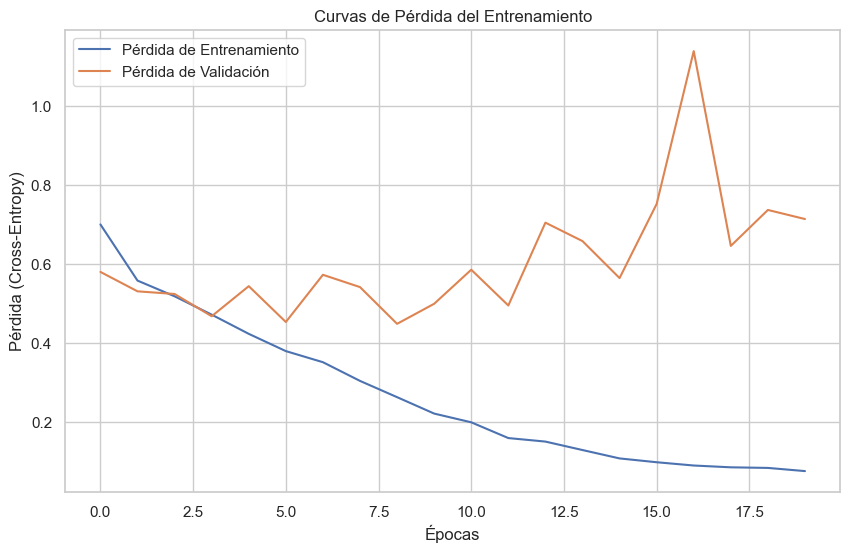

Evaluando en conjunto de prueba: 100%|██████████| 22/22 [00:05<00:00,  3.75it/s]



--- Reporte de Clasificación (Modelo 1D-CNN) ---
                precision    recall  f1-score   support

        Asthma       0.00      0.00      0.00         1
Bronchiectasis       1.00      0.40      0.57        10
 Bronchiolitis       0.80      0.25      0.38        16
          COPD       0.90      0.97      0.93       575
       Healthy       0.35      0.19      0.24        32
          LRTI       1.00      0.33      0.50         3
     Pneumonia       0.35      0.24      0.29        29
          URTI       0.33      0.38      0.35        24

      accuracy                           0.85       690
     macro avg       0.59      0.34      0.41       690
  weighted avg       0.83      0.85      0.83       690


--- Matriz de Confusión (Modelo 1D-CNN) ---


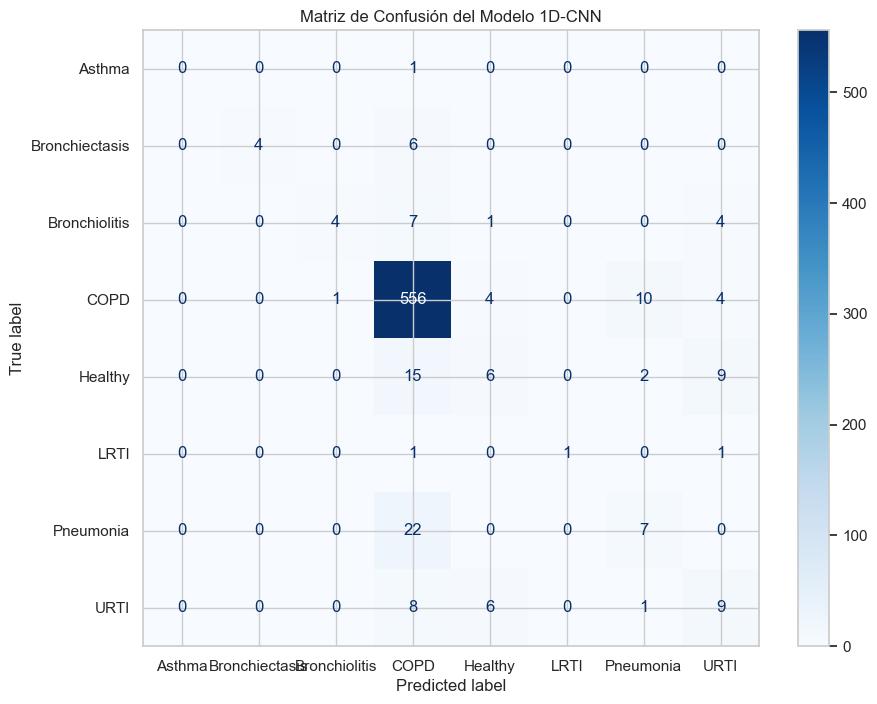

In [9]:
# Graficar curvas de pérdida
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.title('Curvas de Pérdida del Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Cross-Entropy)')
plt.legend()
plt.show()

# Evaluación en el conjunto de prueba
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluando en conjunto de prueba"):
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Reporte de Clasificación y Matriz de Confusión
print("\n--- Reporte de Clasificación (Modelo 1D-CNN) ---")
print(classification_report(all_labels, all_preds, target_names=le.classes_, zero_division=0))

print("\n--- Matriz de Confusión (Modelo 1D-CNN) ---")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, display_labels=le.classes_, cmap='Blues', ax=ax)
plt.title("Matriz de Confusión del Modelo 1D-CNN")
plt.show()



## Análisis de Rendimiento del Modelo 1D-CNN (Iteración Inicial)

Se ha completado un ciclo de entrenamiento inicial para el modelo de Red Neuronal Convolucional 1D (1D-CNN). El siguiente análisis desglosa el rendimiento cuantitativo y cualitativo del modelo, diagnostica sus limitaciones actuales y establece una dirección estratégica para las futuras iteraciones.

---
### 1. Evaluación Cuantitativa
El reporte de clasificación muestra métricas globales superficialmente aceptables, con una **exactitud (`accuracy`) del 85%** y un **F1-score ponderado de 0.83**. Sin embargo, estas cifras son engañosas debido al severo desbalance de clases en el dataset. El `macro avg f1-score` de solo 0.41 revela un rendimiento pobre en las clases minoritarias.

El análisis por clase evidencia esta debilidad:
* **Clase Mayoritaria (`COPD`):** El modelo exhibe un alto rendimiento con un `recall` de 0.97 y un F1-score de 0.93.
* **Clases Minoritarias Clave:** El rendimiento es inaceptablemente bajo en clases críticas. El `recall` para **`Healthy` es de solo 0.19** y para **`Pneumonia` es de 0.24**. Esto indica que el modelo es incapaz de identificar correctamente la mayoría de los casos de estas condiciones.

---
### 2. Análisis de la Matriz de Confusión
La matriz de confusión confirma el diagnóstico cuantitativo. Se observa una **fuerte polarización de las predicciones hacia la clase `COPD`**. Esto es visible en la columna "Predicted label: COPD", que acumula la mayoría de los errores del modelo. Específicamente, el modelo clasificó erróneamente:
* **22** casos de `Pneumonia` como `COPD`.
* **15** casos de `Healthy` como `COPD`.
* **8** casos de `URTI` como `COPD`.

Este patrón demuestra que el modelo ha desarrollado un sesgo significativo, optando por la clase mayoritaria ante la incertidumbre.

---
### 3. Diagnóstico de Sobreajuste (Overfitting)
La gráfica de las curvas de pérdida proporciona el diagnóstico más crítico de esta iteración.
* La **Pérdida de Entrenamiento (línea azul)** desciende de manera consistente a lo largo de las épocas, lo que indica que el modelo está aprendiendo exitosamente los patrones del conjunto de datos de entrenamiento.
* La **Pérdida de Validación (línea naranja)**, por el contrario, solo disminuye durante las primeras 2-3 épocas. A partir de ese punto, comienza a ascender de forma errática y pronunciada, divergiendo significativamente de la curva de entrenamiento.

Este comportamiento es una evidencia inequívoca de **sobreajuste (overfitting)**. El modelo ha comenzado a memorizar el ruido y las particularidades del set de entrenamiento, perdiendo su capacidad para generalizar a datos no vistos.

---
### 4. Conclusión Estratégica
El modelo 1D-CNN en su estado actual **no es viable para producción**. Su rendimiento está inflado por su buen desempeño en una única clase y sufre de un sobreajuste severo que le impide generalizar.

Los siguientes pasos deben centrarse de manera prioritaria en **atacar la raíz del problema: el sobreajuste**. La estrategia a seguir no es modificar la arquitectura en este punto, sino robustecer el proceso de entrenamiento mediante la implementación de **técnicas de regularización**. Las acciones inmediatas deben ser:
1.  **Aumentación de Datos (Data Augmentation):** Para enriquecer el set de entrenamiento y enseñar al modelo a ser invariante a pequeñas perturbaciones.
2.  **Parada Temprana (Early Stopping):** Para detener el entrenamiento en el punto óptimo, antes de que el sobreajuste degrade el rendimiento.

## Iteración 2: Re-entrenamiento con Técnicas de Regularización

Basado en el diagnóstico anterior, ahora implementaremos un pipeline de entrenamiento más robusto para mejorar la generalización del modelo.

In [10]:
# Importar librerías adicionales
import torchaudio
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Clase EarlyStopping 
class EarlyStopping:
    """Implementa Early Stopping para detener el entrenamiento cuando la pérdida de validación no mejora."""
    def __init__(self, patience=7, min_delta=0.001, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.path = path
        logger.info(f"EarlyStopping inicializado con paciencia de {patience} épocas.")

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            logger.info(f"Mejora de validación. Pérdida: {val_loss:.4f}. Guardando modelo en {self.path}")
        else:
            self.counter += 1
            logger.info(f"No hay mejora. Contador de Early Stopping: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                logger.info("Early Stopping activado.")
                return True
        return False

# --- NUEVO CÓDIGO CORREGIDO ---
# 1. Definimos una función que aplica transformaciones a la onda de audio
def augment_waveform(waveform_tensor):
    """
    Aplica aumentaciones directamente a la señal de audio cruda.
    """
    # Aplicar un cambio de volumen aleatorio (Gain)
    gain_factor = torch.empty(1).uniform_(0.7, 1.3).item()
    waveform_tensor = waveform_tensor * gain_factor
    
    # Añadir una pequeña cantidad de ruido Gaussiano
    noise_factor = 0.005
    noise = torch.randn_like(waveform_tensor) * noise_factor
    waveform_tensor = waveform_tensor + noise
    
    # Asegurarse de que la señal no se salga de los límites [-1, 1]
    waveform_tensor = torch.clamp(waveform_tensor, -1, 1)
    
    return waveform_tensor

# 2. Actualizamos la clase Dataset para usar esta nueva función
class RespiratorySoundDataset(Dataset):
    """Dataset actualizado para aplicar aumentación de datos a nivel de onda."""
    
    def __init__(self, df: pd.DataFrame, le: LabelEncoder, fixed_length: int, apply_augmentation: bool = False):
        self.df = df
        self.le = le
        self.fixed_length = fixed_length
        self.apply_augmentation = apply_augmentation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        signal, sr = load_audio_segment(row['audio_path'], row['start_time'], row['end_time'])
        signal_filtered = bandpass_filter(signal, sr, lowcut=100, highcut=1999)
        signal_norm = normalize_signal(signal_filtered)
        
        if len(signal_norm) < self.fixed_length:
            signal_padded = np.pad(signal_norm, (0, self.fixed_length - len(signal_norm)), 'constant')
        else:
            signal_padded = signal_norm[:self.fixed_length]
            
        signal_tensor = torch.tensor(signal_padded, dtype=torch.float32).unsqueeze(0)
        
        # Aplicar la nueva aumentación de onda
        if self.apply_augmentation:
            signal_tensor = augment_waveform(signal_tensor)
            
        label = self.le.transform([row['diagnosis']])[0]
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return signal_tensor, label_tensor

logger.info("Clase Dataset y función de aumentación actualizadas.")

2025-07-23 19:53:17,431 - INFO - Clase Dataset y función de aumentación actualizadas.


In [11]:
# Crear nuevas instancias del Dataset, aplicando aumentación solo al de entrenamiento
train_dataset_aug = RespiratorySoundDataset(train_df, le, FIXED_LENGTH_SAMPLES, apply_augmentation=True)
val_dataset_aug = RespiratorySoundDataset(val_df, le, FIXED_LENGTH_SAMPLES, apply_augmentation=False) # La validación no se aumenta
test_dataset_aug = RespiratorySoundDataset(test_df, le, FIXED_LENGTH_SAMPLES, apply_augmentation=False) # El test nunca se aumenta

# Nuevos DataLoaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=BATCH_SIZE, shuffle=False)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=BATCH_SIZE, shuffle=False)

# Re-instanciar el modelo para empezar con pesos limpios
model_v2 = Simple1DCNN(num_classes=NUM_CLASSES, input_length=FIXED_LENGTH_SAMPLES).to(DEVICE)

# Instanciar nuevas herramientas de entrenamiento
optimizer_v2 = torch.optim.Adam(model_v2.parameters(), lr=LEARNING_RATE)
early_stopping_v2 = EarlyStopping(patience=10, path=BEST_MODEL_PATH)
scheduler_v2 = ReduceLROnPlateau(optimizer_v2, mode='min', factor=0.2, patience=4)

logger.info("Todo listo para el segundo ciclo de entrenamiento.")

2025-07-23 19:53:17,466 - INFO - Tamaño aplanado detectado para la capa lineal: 128
2025-07-23 19:53:17,471 - INFO - EarlyStopping inicializado con paciencia de 10 épocas.
2025-07-23 19:53:17,473 - INFO - Todo listo para el segundo ciclo de entrenamiento.


In [12]:
# Bucle de Entrenamiento Mejorado
history_v2 = {'train_loss': [], 'val_loss': []}
logger.info("Iniciando entrenamiento MEJORADO del modelo 1D-CNN...")

for epoch in range(EPOCHS):
    model_v2.train()
    running_train_loss = 0.0
    for inputs, labels in tqdm(train_loader_aug, desc=f"Época {epoch+1}/{EPOCHS} [Entrenamiento]"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer_v2.zero_grad()
        outputs = model_v2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_v2.step()
        running_train_loss += loss.item() * inputs.size(0)

    model_v2.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader_aug:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model_v2(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_train_loss / len(train_dataset_aug)
    epoch_val_loss = running_val_loss / len(val_dataset_aug)
    history_v2['train_loss'].append(epoch_train_loss)
    history_v2['val_loss'].append(epoch_val_loss)
    
    logger.info(f"Época {epoch+1}/{EPOCHS} - Pérdida Entrenamiento: {epoch_train_loss:.4f}, Pérdida Validación: {epoch_val_loss:.4f}")
    
    scheduler_v2.step(epoch_val_loss)
    if early_stopping_v2(epoch_val_loss, model_v2):
        break

logger.info("Entrenamiento finalizado.")

2025-07-23 19:53:17,495 - INFO - Iniciando entrenamiento MEJORADO del modelo 1D-CNN...
Época 1/20 [Entrenamiento]: 100%|██████████| 173/173 [01:16<00:00,  2.26it/s]
2025-07-23 19:54:39,381 - INFO - Época 1/20 - Pérdida Entrenamiento: 0.7126, Pérdida Validación: 0.5943
2025-07-23 19:54:39,399 - INFO - Mejora de validación. Pérdida: 0.5943. Guardando modelo en ..\models\cnn_best_model.pth
Época 2/20 [Entrenamiento]: 100%|██████████| 173/173 [01:16<00:00,  2.26it/s]
2025-07-23 19:56:01,868 - INFO - Época 2/20 - Pérdida Entrenamiento: 0.5892, Pérdida Validación: 0.5314
2025-07-23 19:56:01,876 - INFO - Mejora de validación. Pérdida: 0.5314. Guardando modelo en ..\models\cnn_best_model.pth
Época 3/20 [Entrenamiento]: 100%|██████████| 173/173 [01:19<00:00,  2.18it/s]
2025-07-23 19:57:28,313 - INFO - Época 3/20 - Pérdida Entrenamiento: 0.5277, Pérdida Validación: 0.4883
2025-07-23 19:57:28,322 - INFO - Mejora de validación. Pérdida: 0.4883. Guardando modelo en ..\models\cnn_best_model.pth
Époc

2025-07-23 20:20:05,271 - INFO - Cargado el mejor modelo desde ..\models\cnn_best_model.pth para la evaluación final.


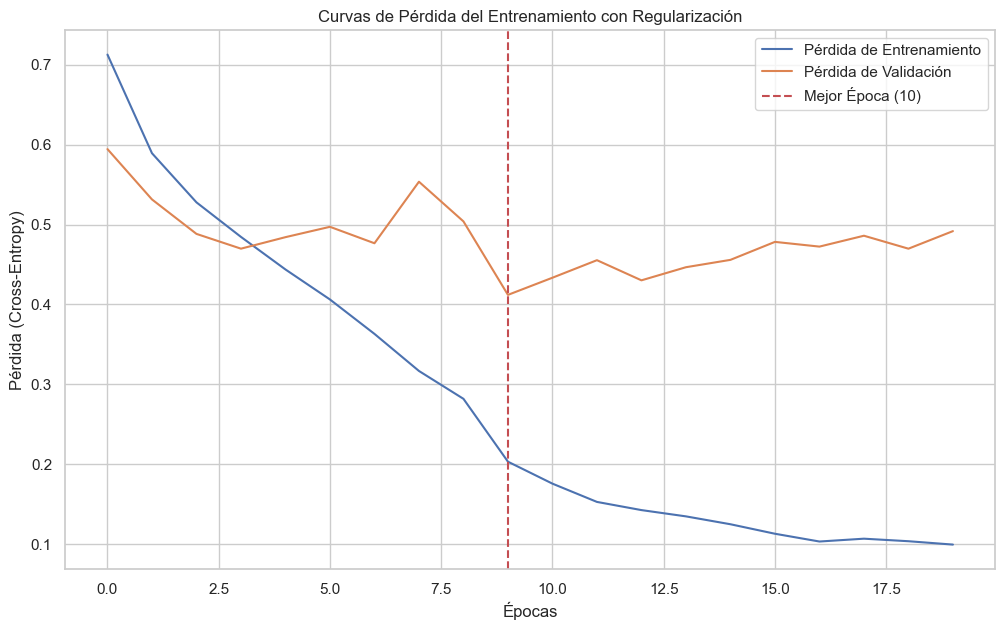

Evaluando en conjunto de prueba: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s]



--- Reporte de Clasificación (Modelo 1D-CNN Mejorado) ---
                precision    recall  f1-score   support

        Asthma       0.00      0.00      0.00         1
Bronchiectasis       0.75      0.30      0.43        10
 Bronchiolitis       0.36      0.31      0.33        16
          COPD       0.92      0.97      0.95       575
       Healthy       0.42      0.41      0.41        32
          LRTI       0.00      0.00      0.00         3
     Pneumonia       0.36      0.14      0.20        29
          URTI       0.36      0.38      0.37        24

      accuracy                           0.86       690
     macro avg       0.40      0.31      0.34       690
  weighted avg       0.84      0.86      0.84       690


--- Matriz de Confusión (Modelo 1D-CNN Mejorado) ---


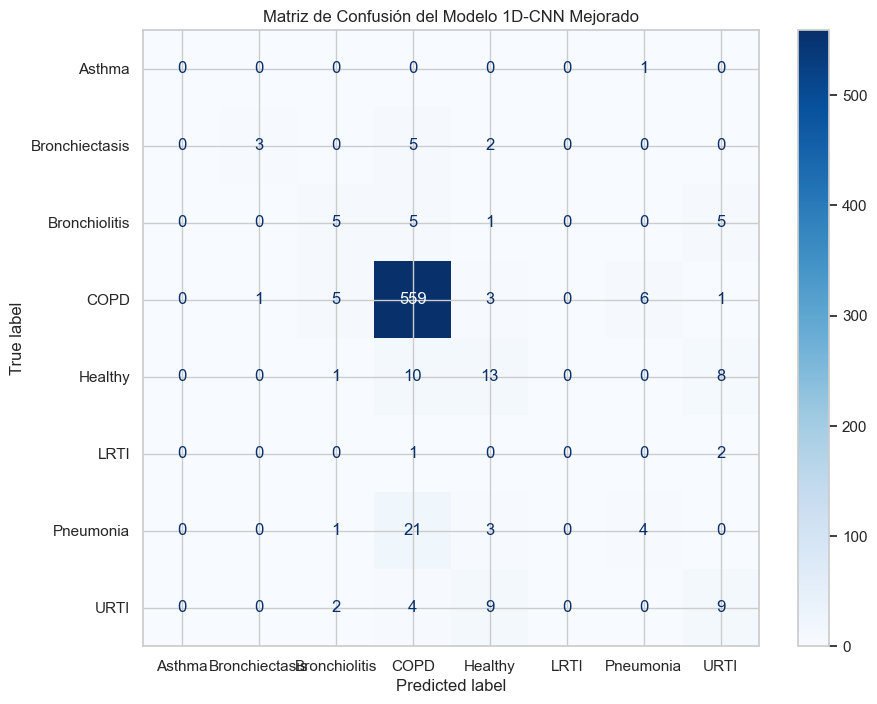

In [13]:
# Cargar el mejor modelo guardado por Early Stopping
model_v2.load_state_dict(torch.load(BEST_MODEL_PATH))
logger.info(f"Cargado el mejor modelo desde {BEST_MODEL_PATH} para la evaluación final.")

# Graficar curvas de pérdida
plt.figure(figsize=(12, 7))
plt.plot(history_v2['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history_v2['val_loss'], label='Pérdida de Validación')
# Marcar el punto donde se detuvo el entrenamiento
best_epoch = np.argmin(history_v2['val_loss'])
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Mejor Época ({best_epoch+1})')
plt.title('Curvas de Pérdida del Entrenamiento con Regularización')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluación final en el conjunto de prueba
model_v2.eval()
all_preds_v2 = []
all_labels_v2 = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader_aug, desc="Evaluando en conjunto de prueba"):
        inputs = inputs.to(DEVICE)
        outputs = model_v2(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_v2.extend(preds.cpu().numpy())
        all_labels_v2.extend(labels.cpu().numpy())

print("\n--- Reporte de Clasificación (Modelo 1D-CNN Mejorado) ---")
print(classification_report(all_labels_v2, all_preds_v2, target_names=le.classes_, zero_division=0))

print("\n--- Matriz de Confusión (Modelo 1D-CNN Mejorado) ---")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(all_labels_v2, all_preds_v2, display_labels=le.classes_, cmap='Blues', ax=ax)
plt.title("Matriz de Confusión del Modelo 1D-CNN Mejorado")
plt.show()

## Análisis de Rendimiento del Modelo 1D-CNN con Regularización (Iteración 2)

Esta segunda iteración se centró en combatir el sobreajuste (overfitting) diagnosticado en el entrenamiento inicial. Se implementaron tres técnicas clave: Aumentación de Datos, Parada Temprana (Early Stopping) y un Planificador de Tasa de Aprendizaje.

---
### 1. Evaluación del Impacto de la Regularización
La implementación de las técnicas de regularización ha sido **exitosa en mitigar el sobreajuste severo** que se observó en la primera iteración.

* **Evidencia en las Curvas de Pérdida:** La evidencia principal se encuentra en la gráfica de las curvas de pérdida. A diferencia de la ejecución anterior donde la pérdida de validación divergía drásticamente, en esta iteración la curva se mantiene estable y la brecha con la pérdida de entrenamiento es significativamente menor.
* **Funcionamiento de Early Stopping:** El mecanismo de Parada Temprana funcionó como se esperaba, identificando la **época 10 como el punto óptimo** (el de menor pérdida de validación) y previniendo que el modelo continuara entrenando más allá de este punto.

---
### 2. Análisis Cuantitativo de las Métricas
A pesar del éxito en la regularización, el impacto en las métricas de clasificación finales es mixto, con una **exactitud general del 86%** y un **F1-score ponderado de 0.84**. Esto revela la complejidad subyacente del problema.

* **Mejoras Notables:** Se observa una **mejora sustancial en la clase `Healthy`**, cuyo F1-score aumentó a **0.41**. El `recall` para esta clase se duplicó a 0.41, lo que indica que el modelo ahora es dos veces mejor para identificar correctamente a los pacientes sanos.
* **Rendimiento Insuficiente y Regresiones:** A pesar de la mejora en `Healthy`, el rendimiento en otras clases minoritarias sigue siendo muy bajo e incluso ha empeorado en algunos casos. El F1-score para **`Pneumonia` es de solo 0.20** y para **`Bronchiolitis` es de 0.33**.
* **Sesgo Persistente:** La matriz de confusión muestra que el **sesgo hacia la clase mayoritaria (`COPD`) sigue siendo el problema dominante**. El modelo todavía clasifica erróneamente un gran número de otras patologías como `COPD`, por ejemplo, 21 casos de `Pneumonia`.

---
### 3. Conclusión Estratégica y Siguientes Pasos
Hemos logrado un hito importante: ahora tenemos un **proceso de entrenamiento estable y regularizado**. Sin embargo, los resultados demuestran que, para este dataset, la arquitectura **1D-CNN sobre audio crudo podría haber alcanzado su techo de rendimiento**. Incluso con un entrenamiento robusto, le cuesta trabajo encontrar los patrones suficientemente distintivos para diferenciar las clases minoritarias.

El camino a seguir es claro:
1.  **Documentar el Logro:** Hemos demostrado exitosamente cómo diagnosticar y solucionar el sobreajuste en un modelo de Deep Learning, una habilidad fundamental.
2.  **Escalar la Estrategia:** Es el momento perfecto para ejecutar el siguiente paso de nuestro plan: **implementar un modelo con una capacidad de representación de características superior**.


In [14]:
from torchviz import make_dot

# 1. Re-instanciar el modelo para asegurarse de que esté en la CPU y en modo de evaluación
#    (esto es solo para la visualización, no afecta tu modelo entrenado)
vis_model = Simple1DCNN(num_classes=NUM_CLASSES, input_length=FIXED_LENGTH_SAMPLES).to('cpu')
vis_model.eval()

# 2. Crear un "dato falso" (dummy input) con la forma que espera el modelo
#    (batch_size=1, channels=1, length=FIXED_LENGTH_SAMPLES)
dummy_input = torch.randn(1, 1, FIXED_LENGTH_SAMPLES)

# 3. Generar el grafo del modelo
#    Pasamos el dato falso a través del modelo para trazar las operaciones
output = vis_model(dummy_input)
dot = make_dot(output, params=dict(vis_model.named_parameters()))

# 4. Guardar el diagrama como un archivo PNG
dot.render("cnn_model_architecture", format="png")

print("Diagrama del modelo guardado como 'cnn_model_architecture.png'")

2025-07-23 20:29:24,556 - INFO - Tamaño aplanado detectado para la capa lineal: 128


Diagrama del modelo guardado como 'cnn_model_architecture.png'
